We have reimplemented the original paper's code in Keras with a few modifications dou to hw limitations. We have also added a learning based method for estimateing correct exposure times. 


We have switched to using RGB images instead of Bayer filters. It makes the model more general and can be applied to more images not only RAW ones.

In [1]:
EPOCHS = 1
PS = 256
HEIGHT = 1424*2
WIDTH = 2128*2
BATCHSIZE = 32
LEARNING_RATE = 0.001
NUMBER_OF_CROPS = 4

All of the important hyperparams can be see above. If we want to tweek the model we only need to chenge the numbers here.

In [2]:
#IMPORTS:
import os
import skimage.io as io
import skimage.transform as trans

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

import rawpy
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

from keras.layers import Lambda
import tensorflow as tf

import time

Here are all the imports.

In [3]:
trainPath = "/home/takats_balint1/deephf/data/Sony_train_list.txt"
testPath = "/home/takats_balint1/deephf/data/Sony_test_list.txt"
valPath = "/home/takats_balint1/deephf/data/Sony_val_list.txt"
replaceString = "/home/takats_balint1/deephf/data"

Path to the training data.

In [4]:
trainData = []
with open(trainPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        trainData.append([data, truth])
print (len(trainData))

1865


In [5]:
valData = []
with open(valPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        # If we had much more data we would consider reserveing the memory first.
        valData.append([data, truth])
print (len(valData))

234


In [6]:
testData = []
with open(testPath) as File:
    for line in File:
        data, truth, _, _ = line.split()
        data = data.replace(".", replaceString, 1)
        truth = truth.replace(".", replaceString, 1)
        # This method is slow but we only have a 1000 lines so this quick and dirty algortihm will do just fine
        testData.append([data, truth])
print (len(testData))

598


In [7]:

def unet(input_size = (None, None, 3)):
    inputs = Input(input_size)

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs) # (s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
 
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
 
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
 
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c10 = Conv2D(3, (1, 1))(c9)
    c10 = concatenate([c10, inputs])
    outputs = Conv2D(3, (1, 1))(c10)

    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model


We have modified the original UNET architecture in a few different ways. We have added batchnorm to speed up training. We have not been able to succecfuly train the model so we have not verified if it does indeed decreases convergence time. 

In [8]:
def ratio(in_path, truth_path):
    in_exposure = float(in_path[53:-5])
    #print(in_exposure)
    gt_exposure = float(truth_path[-7:-5])
    #print(gt_exposure)
    ratio = min(gt_exposure / in_exposure, 300)
    return ratio

We are hoping to replace this function with a learning based aproach. Right now we are calculating the correct expo based on metadata and not based on the images. 

In [9]:
from tensorflow.keras.callbacks import Callback
class TrainingHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.valid_losses = []
        self.accs = []
        self.valid_accs = []
        self.epoch = 0
     
    def on_epoch_end(self, epoch, logs={}):
        self.losses.append(logs.get('loss'))
        self.valid_losses.append(logs.get('val_loss'))
        self.accs.append(logs.get('acc'))
        self.valid_accs.append(logs.get('val_acc'))
        self.epoch += 1
            
history = TrainingHistory()

patience = 4
early_stopping = EarlyStopping(patience=patience, verbose=1)

checkpointer = ModelCheckpoint(filepath='weights.hdf5', save_best_only=True, verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=20, min_lr=10e-5)

In [10]:
Model = unet()
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(lr = LEARNING_RATE)
Model.compile(optimizer = Adam(lr = LEARNING_RATE), loss = "mse", metrics = ['accuracy'])

In [26]:
# We load the model here
Model = tf.keras.models.load_model('my_model')

In [11]:
for epoch in range(EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    
    trainPermutation = np.random.permutation(len(trainData[:32*2]))
    trainBatch = [None]*BATCHSIZE
    truthBatch = [None]*BATCHSIZE
    for j in range(0,len(trainPermutation), BATCHSIZE//NUMBER_OF_CROPS):
        
        start_time = time.time()
        
        for k in range(BATCHSIZE//NUMBER_OF_CROPS):
            trainPath = trainData[trainPermutation[j+k]][0]
            truthPath = trainData[trainPermutation[j+k]][1]
            RATIO = ratio(trainPath,truthPath)
            raw = rawpy.imread(trainPath)

            raw = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            raw = np.expand_dims(np.float32(raw / 65535.0), axis=0)
        
            gt_raw = rawpy.imread(truthPath)
            im = gt_raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)
            gt_image = np.expand_dims(np.float32(im / 65535.0), axis=0)
            # To speed up loadtimes we use an already loaded image NUMBER_OF_CROPS times.
            # So we save a lot of I/O
            for crop in range(NUMBER_OF_CROPS):
                xx = np.random.randint(0, WIDTH - PS)
                yy = np.random.randint(0, HEIGHT - PS)
                input_patch = raw[:, yy:yy + PS, xx:xx + PS, :]
                # gt_patch = gt_image[:, yy * 2:yy * 2 + PS * 2, xx * 2:xx * 2 + PS * 2, :]
                gt_patch = gt_image[:, yy:yy + PS, xx:xx + PS, :]
        
                input_patch = np.minimum(input_patch, 1.0)
                trainBatch[k*NUMBER_OF_CROPS+crop] = input_patch*RATIO
                truthBatch[k*NUMBER_OF_CROPS+crop] = gt_patch
            
        load_end_time = time.time()
        
        
        
        # Model.fit(input_patch, gt_patch)
        trainOut = Model.train_on_batch(input_patch, gt_patch)
        print("Loss: {}".format(round(trainOut[0], 4)))
        print("Accuracy: {}".format(round(trainOut[1], 4)))
        load_end_time = time.time()
        print("\nEnd of batch %d" % (j//(BATCHSIZE//NUMBER_OF_CROPS),))
        print("Load time taken: " + str(load_end_time-start_time))
        #We save the model after a few batches 
        if j % ((BATCHSIZE//NUMBER_OF_CROPS)*4) == 0:
            Model.save("my_model")


Start of epoch 0
Loss: 0.2861
Accuracy: 0.2123

End of batch 0
Load time taken: 33.88035345077515
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model/assets
Loss: 0.0334
Accuracy: 0.3184

End of batch 1
Load time taken: 28.33868169784546
Loss: 0.4554
Accuracy: 0.2327

End of batch 2
Load time taken: 27.463014364242554
Loss: 0.4048
Accuracy: 0.2371

End of batch 3
Load time taken: 27.159804344177246
Loss: 0.5775
Accuracy: 0.2351

End of batch 4
Load time taken: 26.875486850738525
Loss: 0.3399
Accuracy: 0.2995

End of batch 5
Load time taken: 26.994985342025757
Loss: 0.2787
Accuracy: 0.293

End of batch 6
Load time taken: 27.134689807891846
Loss: 0.2445
Accuracy: 0.2369

End of batch 7
Load time taken: 27.088643789291382


Unfortunately it takes a lot of time to train our model. We have a memory bottleneck. Passing an image  through the model takes approximately 2 secs. However loading the data takes 13 times longer. At each train step we have to load BTACHSIZE//NUMBER_OF_CROPS amount of RAW images. This can be severaly 100MBs.

With the trained model we make a prediction. We have not done any testing or validation because we have not been able to train the model fully due to hw limitations.

In [15]:
raw = rawpy.imread(testData[30][0])
#raw = np.expand_dims(pack_raw(raw), axis=0)
raw = raw.postprocess(use_camera_wb=True, half_size=False, no_auto_bright=True, output_bps=16)

raw = np.expand_dims(np.float32(raw / 65535.0), axis=0)

#input_patch = raw[:,0:1024,0:1024,:]
input_patch = raw*ratio(testData[30][0],testData[30][1])
#input_patch = raw


input_patch = np.minimum(input_patch, 1.0)

test_out = Model.predict(input_patch)

test_out =  test_out
test_out = np.minimum(np.maximum(0, test_out),1)
print(test_out)

[[[[0.05729285 0.00708001 0.        ]
   [0.06408769 0.03365714 0.00650559]
   [0.11542924 0.         0.        ]
   ...
   [0.08914056 0.         0.        ]
   [0.02810866 0.         0.        ]
   [0.         0.         0.        ]]

  [[0.11418407 0.20253955 0.        ]
   [0.14598817 0.07448706 0.03206152]
   [0.11462487 0.         0.        ]
   ...
   [0.14722772 0.         0.        ]
   [0.         0.         0.        ]
   [0.         0.         0.        ]]

  [[0.18379626 0.42977387 0.        ]
   [0.15055487 0.29754212 0.10821637]
   [0.09231897 0.01005148 0.18240613]
   ...
   [0.16943115 0.09977786 0.10800466]
   [0.         0.07682055 0.        ]
   [0.1001416  0.08862869 0.16554052]]

  ...

  [[0.         0.11574926 0.24245442]
   [0.         0.         0.29330373]
   [0.         0.         0.05624437]
   ...
   [0.07807167 0.         0.        ]
   [0.         0.         0.10564259]
   [0.045791   0.         0.        ]]

  [[0.00245321 0.09786662 0.14305867]
   [0. 

In [16]:
print(test_out.shape)
test_out = test_out.reshape(test_out.shape[1], test_out.shape[2], test_out.shape[3])
print(test_out.shape)

(1, 2848, 4256, 3)
(2848, 4256, 3)


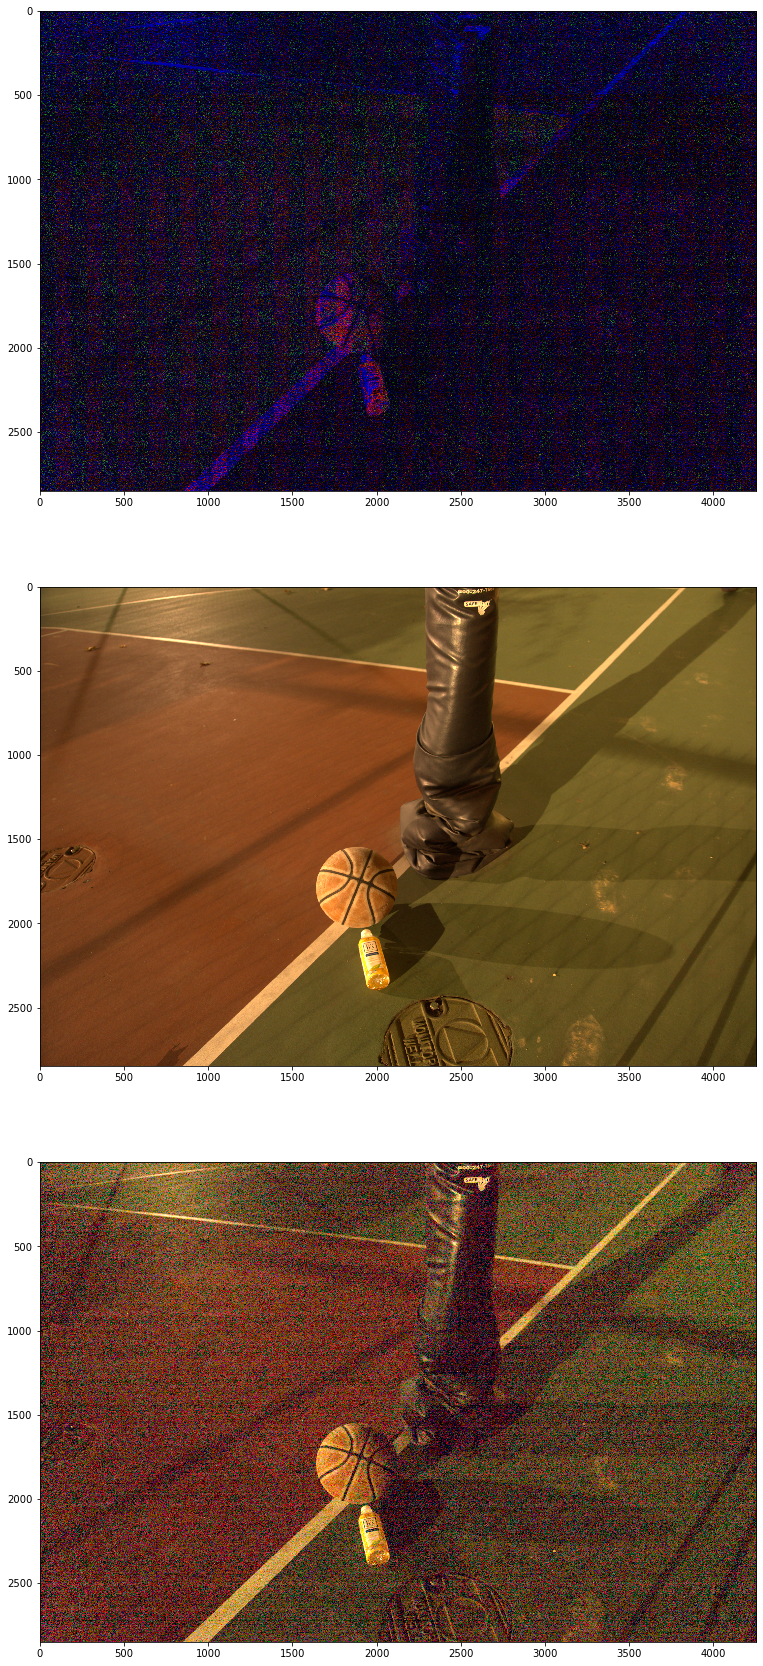

In [17]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from matplotlib import cm

test_truth = rawpy.imread(testData[30][1])
test_truth = test_truth.postprocess()

test_ori = rawpy.imread(testData[30][0])
test_ori = test_ori.postprocess()



fig, axes = plt.subplots(3,1, figsize=(30,30))
axes[0].imshow(test_out, interpolation='nearest')
axes[1].imshow(test_truth, interpolation='nearest')
axes[2].imshow(test_ori, interpolation='nearest')
plt.show()

The model produces the image seen above. It is for some reason green, we have not figured it out why. It has to do with Bayer arrays since it is an RGBG format, meaning it has 2 green channels. The rectangular artifacts may be coused by the display resolution. More training is required.